### Edgar Moises Hernandez-Gonzalez
#### 10/04/20-23/04/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### Resize proporcional de 264x8
##### Data Augmentation
##### 5 ejecuciones independientes

#### CNN-2D
##### Sujeto 1
##### Accuracy = 68.40%
##### Kappa = 0.5787

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [2]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A09T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A09E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA09T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA09E.csv", header=None)

In [4]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [5]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [6]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [7]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
# las etiquetas en categorical para poder entrenar data augmentation
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (8, 264) #ancho, alto
  fs = 250
  datos = np.zeros((288,264,8))
  temporal = np.zeros((528,4))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [10]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

0
100
200
0
100
200


In [11]:
print(x_train.shape)
print(x_test.shape)

(288, 264, 8)
(288, 264, 8)


In [12]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

555.4778442263605
438.20612701137344
0.0009535630504462418
0.0007544479629820306
3.941017589997236
4.0973010062929935


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 556.0
x_test /= 556.0

In [14]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.99906087
0.7881405
1.7150414e-06
1.3569207e-06
0.007088162
0.0073692487


In [15]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 264, 8, 1)
(288, 264, 8, 1)


In [0]:
datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [0]:
# usar el .hdf5
# mc = ModelCheckpoint('best.h5', monitor='val_accuracy', save_best_only=True)
mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_STFTDA09.hdf5',
                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [0]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1

Epoch 00001: val_accuracy improved from -inf to 0.25694, saving model to /content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_STFTDA09.hdf5

Epoch 00002: val_accuracy did not improve from 0.25694

Epoch 00003: val_accuracy did not improve from 0.25694

Epoch 00004: val_accuracy did not improve from 0.25694

Epoch 00005: val_accuracy did not improve from 0.25694

Epoch 00006: val_accuracy did not improve from 0.25694

Epoch 00007: val_accuracy did not improve from 0.25694

Epoch 00008: val_accuracy did not improve from 0.25694

Epoch 00009: val_accuracy did not improve from 0.25694

Epoch 00010: val_accuracy improved from 0.25694 to 0.26042, saving model to /content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_STFTDA09.hdf5

Epoch 00011: val_accuracy improved from 0.26042 to 0.27083, saving model to /content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_STFTDA09.hdf5

Epoch 00012: val_accuracy improved from 0.27083 to 0.34375, saving model to /content/drive/My Drive/BCI-IV-2a/Modelos/Mod

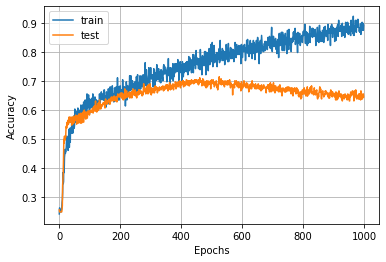

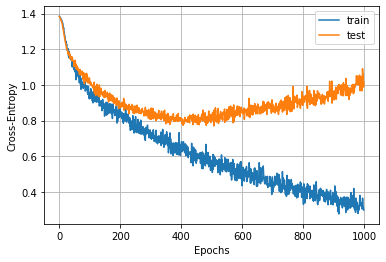

Iteration: 2

Epoch 00001: val_accuracy did not improve from 0.71528

Epoch 00002: val_accuracy did not improve from 0.71528

Epoch 00003: val_accuracy did not improve from 0.71528

Epoch 00004: val_accuracy did not improve from 0.71528

Epoch 00005: val_accuracy did not improve from 0.71528

Epoch 00006: val_accuracy did not improve from 0.71528

Epoch 00007: val_accuracy did not improve from 0.71528

Epoch 00008: val_accuracy did not improve from 0.71528

Epoch 00009: val_accuracy did not improve from 0.71528

Epoch 00010: val_accuracy did not improve from 0.71528

Epoch 00011: val_accuracy did not improve from 0.71528

Epoch 00012: val_accuracy did not improve from 0.71528

Epoch 00013: val_accuracy did not improve from 0.71528

Epoch 00014: val_accuracy did not improve from 0.71528

Epoch 00015: val_accuracy did not improve from 0.71528

Epoch 00016: val_accuracy did not improve from 0.71528

Epoch 00017: val_accuracy did not improve from 0.71528

Epoch 00018: val_accuracy did not 

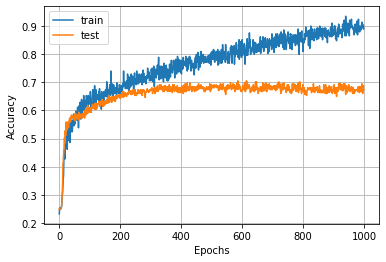

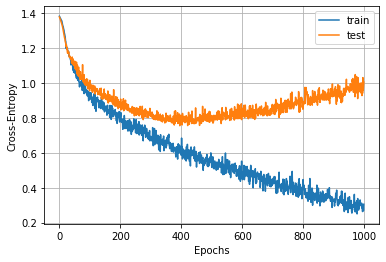

Iteration: 3

Epoch 00001: val_accuracy did not improve from 0.71528

Epoch 00002: val_accuracy did not improve from 0.71528

Epoch 00003: val_accuracy did not improve from 0.71528

Epoch 00004: val_accuracy did not improve from 0.71528

Epoch 00005: val_accuracy did not improve from 0.71528

Epoch 00006: val_accuracy did not improve from 0.71528

Epoch 00007: val_accuracy did not improve from 0.71528

Epoch 00008: val_accuracy did not improve from 0.71528

Epoch 00009: val_accuracy did not improve from 0.71528

Epoch 00010: val_accuracy did not improve from 0.71528

Epoch 00011: val_accuracy did not improve from 0.71528

Epoch 00012: val_accuracy did not improve from 0.71528

Epoch 00013: val_accuracy did not improve from 0.71528

Epoch 00014: val_accuracy did not improve from 0.71528

Epoch 00015: val_accuracy did not improve from 0.71528

Epoch 00016: val_accuracy did not improve from 0.71528

Epoch 00017: val_accuracy did not improve from 0.71528

Epoch 00018: val_accuracy did not 

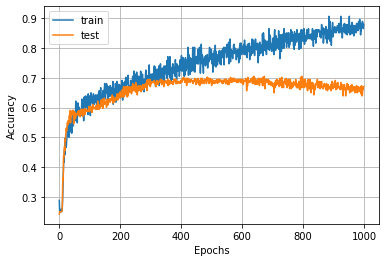

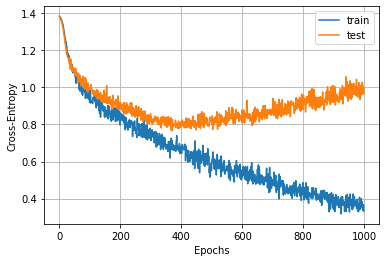

Iteration: 4

Epoch 00001: val_accuracy did not improve from 0.71528

Epoch 00002: val_accuracy did not improve from 0.71528

Epoch 00003: val_accuracy did not improve from 0.71528

Epoch 00004: val_accuracy did not improve from 0.71528

Epoch 00005: val_accuracy did not improve from 0.71528

Epoch 00006: val_accuracy did not improve from 0.71528

Epoch 00007: val_accuracy did not improve from 0.71528

Epoch 00008: val_accuracy did not improve from 0.71528

Epoch 00009: val_accuracy did not improve from 0.71528

Epoch 00010: val_accuracy did not improve from 0.71528

Epoch 00011: val_accuracy did not improve from 0.71528

Epoch 00012: val_accuracy did not improve from 0.71528

Epoch 00013: val_accuracy did not improve from 0.71528

Epoch 00014: val_accuracy did not improve from 0.71528

Epoch 00015: val_accuracy did not improve from 0.71528

Epoch 00016: val_accuracy did not improve from 0.71528

Epoch 00017: val_accuracy did not improve from 0.71528

Epoch 00018: val_accuracy did not 

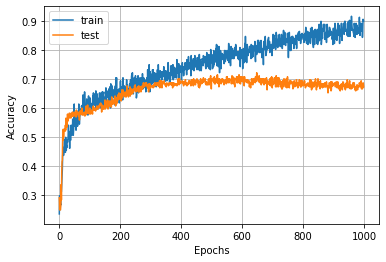

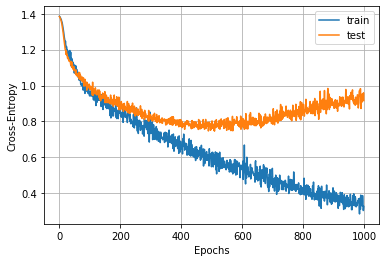

Iteration: 5

Epoch 00001: val_accuracy did not improve from 0.72222

Epoch 00002: val_accuracy did not improve from 0.72222

Epoch 00003: val_accuracy did not improve from 0.72222

Epoch 00004: val_accuracy did not improve from 0.72222

Epoch 00005: val_accuracy did not improve from 0.72222

Epoch 00006: val_accuracy did not improve from 0.72222

Epoch 00007: val_accuracy did not improve from 0.72222

Epoch 00008: val_accuracy did not improve from 0.72222

Epoch 00009: val_accuracy did not improve from 0.72222

Epoch 00010: val_accuracy did not improve from 0.72222

Epoch 00011: val_accuracy did not improve from 0.72222

Epoch 00012: val_accuracy did not improve from 0.72222

Epoch 00013: val_accuracy did not improve from 0.72222

Epoch 00014: val_accuracy did not improve from 0.72222

Epoch 00015: val_accuracy did not improve from 0.72222

Epoch 00016: val_accuracy did not improve from 0.72222

Epoch 00017: val_accuracy did not improve from 0.72222

Epoch 00018: val_accuracy did not 

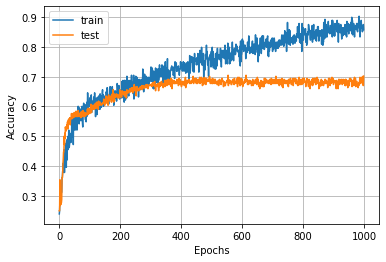

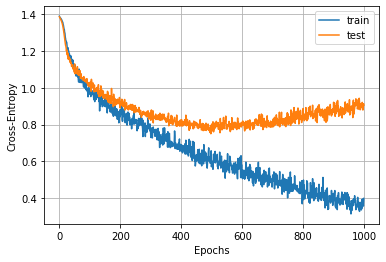


Resultados:
loss: [1.0141754117276933, 1.005587226814694, 0.9652759267224206, 0.916198624504937, 0.9050717949867249]
accuracy: [0.6458333134651184, 0.6736111044883728, 0.6701388955116272, 0.6736111044883728, 0.7013888955116272]
kappa: [0.5277777777777778, 0.5648148148148149, 0.5601851851851851, 0.5648148148148149, 0.6018518518518519]


In [19]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples_train/18),
                                epochs=1000,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0, callbacks=[mc])

  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [20]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 264, 8, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 132, 4, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 132, 4, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 66, 2, 16)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2112)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               270464    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [21]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.6729
std: (+/- 0.0176)
Mean Kappa: 0.5639
std: (+/- 0.0235)
Max Accuracy: 0.7014
Max Kappa: 0.6019
